# Getting started with the readout client

To get started with this project, follow the steps below:

This has been tested on linux with bash and python-3.10 and on Windows with PowerShell and python-3.12. 

## 1. Set up the network

Ensure the RFSoC (eg. 10.11.11.11/24) is connected and on the same subnet. For example, manually set the IP address of the client machine to 10.11.11.1/24.

It should be possible to see the RFSoC from the client machine with a ping:

`ping 10.11.11.11`

SSH should also be possible, for example:

`ssh casper@10.11.11.11`

Optionally, you can set the DNS hostname in the client machine's `/etc/hosts` or `C:\Windows\System32\drivers\etc\hosts` file with a line like this:

`10.11.11.11 rfsoc`

Then you can use the hostname `rfsoc` instead of the IP address in the config file.

## 2. Prepare the environment on the client machine:

Ensure python3 and pip are installed.

Clone the project repository from GitHub: 

`git clone https://github.com/sr-cdf/souk_readout_tools`

Navigate to the project directory: 
`cd souk_readout_tools`

Create a virtual python environment: 

Linux bash: `python3 -m venv client_venv`

Windows PowerShell: `python -m venv client_venv`

Activate the python environment:

Linux bash: `source ./client_venv/bin/activate`

Windows PowerShell: `.\client_venv\Scripts\Activate.ps1`

With PowerShell you may need to set the execution policy to allow running scripts: 

`Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope CurrentUser`

Install the required packages:

`pip install -r requirements.txt`


## 3. Prepare a configuration file:

A basic configuration file with the minimum required parameters is provided in [config/default_config.yaml]('config/default_config.yaml'). This should be used as a template to create a new configuration file with the correct parameters for your setup.

Copy the default configuration file to a new file:

`cp config/default_config.yaml config/my_config.yaml`

Edit the new configuration file with the correct parameters for your setup. 

Important parameters are the RFSoC IP address, the analog frontend configuration, cryostat configuration, and detector information.

The file [config/config.yaml]('config/config.yaml') is a symbolic link and can be used to point to the latest configuration file. In Windows, the symbolic link may simply contain the path to the configuration file.

## 4. Start the client:

Start an interactive python session in the activated virtual environment and create the client interface:

If no config file is provided, the default `config.yaml` symlink will be followed.

```
[user@client souk_readout_tools]$ source ./client_venv/bin/activate
(client_venv) [user@client souk_readout_tools]$ ipython
```

In [1]:

import os
os.chdir(os.path.dirname(os.getcwd()) # change to the parent directory so we can see the readout_client module
                )
import readout_client

client = readout_client.ReadoutClient(config_file='config/my_config.yaml')


## 4. Copy the new configuration to the RFSoC:

New configuration files should be copied to the RFSoC with the method:



In [2]:
client.set_config('config/my_config.yaml')


{'status': 'success'}


TBD: make this implicit.

The server will save the config file to the RFSoC and restart itself to apply the new configuration, which can take upto 30 seconds.


To set a config file as the default config on the RFSoC that will be preserved after power cycling, use the method:

```
client.set_config_default('config/my_config.yaml')

```




## 4. Requesting system information

The current status of the readout server on the RFSoC can be inspected with the `get_server_status` method:

A summary of the current firmware configuration can be obtained with the `get_system_information` method.


In [3]:
client.get_server_status()


{'process_name': 'readout_daemon',
 'ip_addresses': '10.11.11.11 192.168.2.224',
 'pwd': '/home/casper/src/souk_readout_tools',
 'sys.executable': '/home/casper/py38venv/bin/python3',
 'sys.argv': ['readout_server.py'],
 'uname': 'krm4 Linux 5.10.0-xilinx-v2021.2 #1 SMP Tue Oct 12 09:30:57 UTC 2021 aarch64',
 'python_version': '3.8.0 (default, Dec  9 2021, 17:53:27) \n[GCC 8.4.0]',
 'config_file': 'config/my_config.yaml',
 'request_clients': 1,
 'request_client_addrs': [['10.11.11.1', 45756]],
 'stream_clients': 0,
 'stream_client_addrs': [],
 'stream_task_started': False,
 'stream_enabled': False,
 'triggered_stream_task_started': False,
 'triggered_stream_enabled': False,
 'sweep_task_running': False,
 'tasks': 0,
 'firmware_interface_alive': True,
 'firmware_fast_interface_alive': True,
 'system_information': {'fpga_status': {'programmed': True,
   'timestamp': '2024-08-30T14:53:13.059725',
   'host': 'krm4:localhost',
   'antname': None,
   'sw_version': '0.1',
   'fw_version': '7.



## 5. Setting Readout Tones:

Methods are available to set the readout tone frequencies, powers and phase offsets.

Use `set_tone_frequencies`, `set_tone_powers` and `set_tone_phases` to set the desired readout tones. The system will configure the necessary firmware settings to achieve the target frequencies and powers, accounting for the RF-DAC settings, the DAC response, and any analog converter configurations specified in the config file.

In the current configuration we are in a DAC/ADC loopback and have no analog upconversion so we are limited between 0 and 2GHz. 

To set the first tone to 0.9 GHz with -20 dBm and the second tone to 1.1 GHz with -25 dBm, and to apply the optimal phase offsets for the tones, use the following commands:


In [4]:
freqs = [0.900e9, 1.100e9]
powers = [-20, -25]
phases = client.generate_newman_phases(freqs)

client.set_tone_frequencies(freqs)
client.set_tone_powers(powers)
client.set_tone_phases(phases)

print('requested freqs:',freqs)
print('returned freqs:',client.get_tone_frequencies())
print('freqs details:',client.get_tone_frequencies(detailed_output=True))
print()
print('requested powers:',powers)
print('returned powers:',client.get_tone_powers())
print('powers details:',client.get_tone_powers(detailed_output=True))
print()
print('requested phases:',phases)
print('requested phases modulo pi:',(phases+3.141592653589793)%(2*3.141592653589793) - 3.141592653589793)
print('returned phases',client.get_tone_phases())



requested freqs: [900000000.0, 1100000000.0]
returned freqs: [9.0e+08 1.1e+09]
freqs details: {'tx': {'mixer_lo_phase_increment': [0.0, 0.0], 'mixer_lo_ri_step': [[0.999969482421875, 0.0], [0.999969482421875, 0.0]], 'mixer_lo_phase_step': [0.0, 0.0], 'mixer_lo_offset_freq': [0.0, 0.0], 'filterbank_center_freq': [-124000000.0, 76000000.0], 'digital_baseband_freq': [-124000000.0, 76000000.0], 'analog_output_freq': [900000000.0, 1100000000.0], 'rf_output_freq': [900000000.0, 1100000000.0]}, 'rx': {'mixer_lo_phase_increment': [0.0, 0.0], 'mixer_lo_ri_step': [[0.999969482421875, 0.0], [0.999969482421875, 0.0]], 'mixer_lo_phase_step': [0.0, 0.0], 'mixer_lo_offset_freq': [0.0, 0.0], 'filterbank_center_freq': [-124000000.0, 76000000.0], 'digital_baseband_freq': [-124000000.0, 76000000.0], 'analog_input_freq': [900000000.0, 1100000000.0], 'rf_input_freq': [900000000.0, 1100000000.0]}}

requested powers: [-20, -25]
returned powers: [-19.99517348 -24.99508292]
powers details: {'amps': [0.19970703


## 6. Getting Data:

To collect a fixed number of continuous samples, use the `get_samples` method. This method will return a sequence of raw samples from the RFSoC.

The raw samples should be parsed into IQ and meta data using the `parse_samples` method. This method will return a dictionary that can be used to access the IQ data and the meta data.

For example, to collect one second of data and to plot the magnitude of IQ for for the first tone:


Received 500 samples in ~0.989861249923706 seconds (~505.12129860476676 samples per second)
dropped any packets?:  False


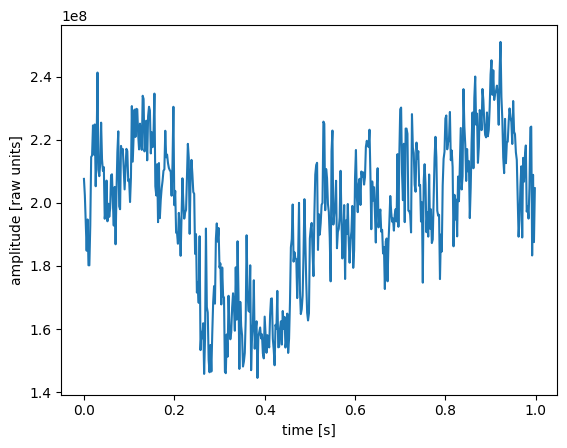

In [13]:
import numpy as np, matplotlib.pyplot as plt

sample_rate = client.get_sample_rate()
print(sample_rate)

num_tones = len(client.get_tone_frequencies())

raw_samples = client.get_samples(sample_rate)

data = client.parse_samples(raw_samples,num_tones)

print('dropped any packets?: ', not np.all(np.diff(data['packet_counter']) == 1) )

t = np.arange(len(data['packet_counter'])) / client.get_sample_rate()

z0 = data['i_data']['0000'] + 1j*data['q_data']['0000']

plt.plot(t, np.abs(z0))
plt.xlabel('time [s]')
plt.ylabel('amplitude [raw units]')
plt.show()


It is important to check the the dac output, adc input, and the DSP pieline are not saturated in any way.

Making use of the DAC snapshot block, we can inspect the DAC output for a short period of time with `check_output_saturation`. 

The values returned by the following function indicate the min and max values recorded for both DACs, scaled to range from -1.0 to 1.0 for a full scale signal. If `'result' == True`, and values are equal to -1.0 or +1.0, then signal driving the DAC is too large and needs to be reduced.


In [6]:
client.check_output_saturation()


{'status': 'success',
 'result': False,
 'details': {'i0max_fs': 0.31060791015625,
  'i0min_fs': -0.31060791015625,
  'q0max_fs': 0.31060791015625,
  'q0min_fs': -0.31060791015625,
  'i1max_fs': 0.0,
  'i1min_fs': 0.0,
  'q1max_fs': 0.0,
  'q1min_fs': 0.0,
  'integration_time': 2e-05}}

Similarly for the ADC input, we can inspect the ADC snapshot for a short period of time with `check_input_saturation`.

The ADC output is scaled from -1.0 to +1.0 and the min and max values are reported. If the `'result' == True, the values are equal to -1.0 or +1.0,so the signal into the ADC is too large and needs to be reduced.

In [7]:
client.check_input_saturation()

{'status': 'success',
 'result': False,
 'details': {'imax_fs': 0.033447265625,
  'imin_fs': -0.03363037109375,
  'qmax_fs': 0.03375244140625,
  'qmin_fs': -0.033416748046875,
  'integration_time': 2e-05}}

Additionally, there are overflow counters for some of the blocks in the DSP pipeline. These should can be monitored with the `check_dsp_overflow` to ensure that the pipeline is not saturating:

The overflow counter values are recorded twice and if there is any difference, then an overflow has been detected. The overflow counters are reset after each read.




In [12]:
client.check_dsp_overflow()

{'status': 'success',
 'result': True,
 'details': {'psbscale_ovf_count_start': 0,
  'psbscale_ovf_count_end': 0,
  'psbscale_ovf_delta': 0,
  'psb_ovf_count_start': 0,
  'psb_ovf_count_end': 0,
  'psb_ovf_delta': 0,
  'pfb_ovf_count_start': 29544164,
  'pfb_ovf_count_end': 31912969,
  'pfb_ovf_delta': 2368805}}

In this example, `'result' == True'`, and inspecting the details reveals that the PFB is overflowing. This can be fixed by applying a different shift schedule. If I update the config entry `config: firmware: :pfb_fftshift` from `0b000000000000` to `0b000000111111` and then apply the new config to the RFSoC, the overflow should be resolved.

[updates config...]

In [9]:
client.check_dsp_overflow()

{'status': 'success',
 'result': False,
 'details': {'psbscale_ovf_count_start': 0,
  'psbscale_ovf_count_end': 0,
  'psbscale_ovf_delta': 0,
  'psb_ovf_count_start': 0,
  'psb_ovf_count_end': 0,
  'psb_ovf_delta': 0,
  'pfb_ovf_count_start': 0,
  'pfb_ovf_count_end': 0,
  'pfb_ovf_delta': 0}}

Success, now I can try taking the data again to compare the results.

Received 500 samples in ~0.9945168495178223 seconds (~502.756690590429 samples per second)
dropped any packets?:  False


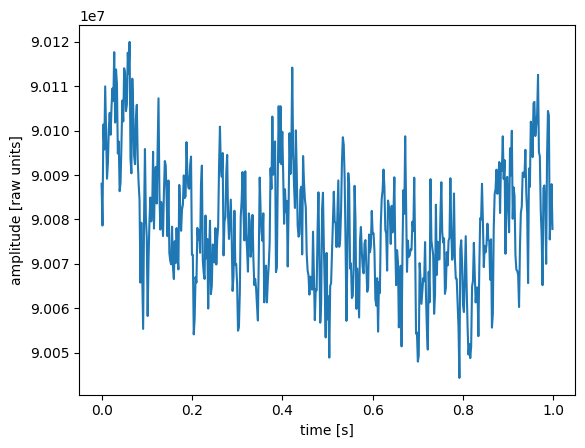

In [10]:

sample_rate = client.get_sample_rate()
print(sample_rate)

num_tones = len(client.get_tone_frequencies())

raw_samples = client.get_samples(sample_rate)

data = client.parse_samples(raw_samples,num_tones)

print('dropped any packets?: ', not np.all(np.diff(data['packet_counter']) == 1) )

t = np.arange(len(data['packet_counter'])) / client.get_sample_rate()

z0 = data['i_data']['0000'] + 1j*data['q_data']['0000']

plt.plot(t, np.abs(z0))
plt.xlabel('time [s]')
plt.ylabel('amplitude [raw units]')
plt.show()

It is also possible to use calibration data in the config, and the firmware settings to convert the raw units to physical dBm at the ADC input:

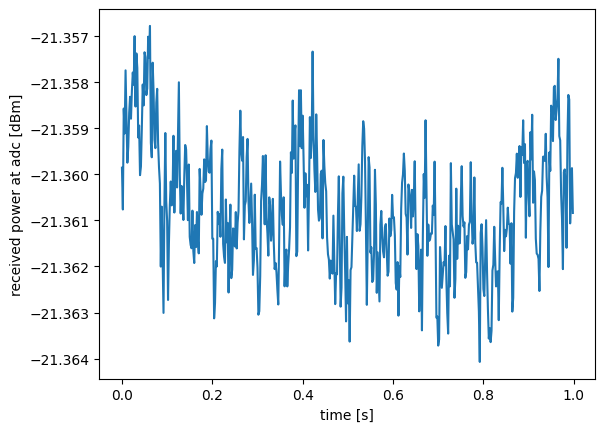

In [11]:
from calibration import calc_adc_input_power
sys_info = client.get_system_information()
power_dbm = calc_adc_input_power(accumulated_iq_level = z0,
                                 adc_dbm_to_dbfs = client.config['firmware']['adc_dbm_to_dbfs'],
                                 mixer_qmc_gain = client.config['firmware']['defaults']['adc_qmc_gain'],
                                 mixer_scale_is_1p0 = client.config['firmware']['defaults']['adc_mixer_scale_1p0'],
                                 adc_bits = client.config['firmware']['adc_fullscale_bits'],
                                 pfb_fftshift = sys_info['pfb_fftshift'],
                                 rx_mix_scale = 1.0,
                                 acclen = sys_info['acc_len'],
                                 windowfactor=1.0)
plt.plot(t,power_dbm,label = 'first tone')
plt.xlabel('time [s]')
plt.ylabel('received power at adc [dBm]')
plt.legend()
plt.show()


TBD: make the conversion more user friendly

## 7 Exporting data

The data dictionary can be exported to a file with the `export_samples` method in npy, json or csv format. Placeholders exist for hdf5 and other formats. For example:

Exported data can also be imported with the `import_samples` method for comparing different data sets. For example:


In [24]:
filename = 'test_samples.csv'

client.export_samples(filename,data)

data2 = client.import_samples(filename)

print(np.all(data['i_data']['0000'] == data2['i_data']['0000']))


True




## 8. Streaming Data:

If continuous streams of arbitrary length are required, the server can be instructed to start streaming, then a seperate client script can be started to record the stream to disk. The server stream or the client logger can be stopped at any time. For example:

With a client, call the `enable_stream` method:

```
In [29]: client.enable_stream()
```
Then, in a separate terminal, start the logger script, specifying the number of tones to save (saving all 2048 tones can waste disk space when only a handful are being used):

Linux bash: 

```
(client_venv)[user@client souk_readout_tools]$ python3 client_scripts/receive_stream.py -p -n 2
```

Or windows powershell: 
```
(client_venv) PS C:\Users\user\souk_readout_tools> python client_scripts\receive_stream.py -p -n 2
```


The `-p` flag will print the latest sample to the screen in the terminal. The `-n` flag specifies the number of tones to save to disk. 

By default the script will save raw data into `./tmp/tmp_stream`, overwriting any existing data there, but a directory and filename can be specified with `-d` and `-f` flags.

A format file will also be saved in the same directory as the data file, containing the information required to parse the raw dumped stream.

To stop the stream, call the `disable_stream` method in the client:

```
In [30]: client.disable_stream()
```

The receiver script can be stopped with `Ctrl-C`, or it can be left running, ready to continue appending to the file when the stream is re-enabled.

Raw data stream files can be parsed with the `parse_stream` method in the client:

```
In [29]: data = client.parse_stream('tmp/tmp_stream')
In [30]: t = np.arange(len(data['packet_counter'])) / data['sample_rate']
In [31]: z0 = data['i_data']['0000'] + 1j*data['q_data']['0000']
In [32]: plt.plot(t, np.abs(z0))
In [33]: plt.show()

```

## 9. Triggered Streaming:

The server can be configured to send a sample when a trigger pulse is received on a GPIO input. The process is identical to regular streaming except that we have to call `enable_triggered_stream` instead of `enable_stream`:

```
client.enable_triggered_stream()
```

Note that the packet counter increments by one for every new sample, regardless of whether the sample was sent out on a trigger or not. The trigger signal is not recorded in the data stream, but the time of the trigger can be inferred from the packet counter and the sample rate.

## 10. Frequency sweeping:

To perform a frequency sweep of readout tones, use `perform_sweep` and pass the center frequencies, the spans for each tone (can be a single span that applies to all tones), the number of points to sweep, the number of samples to integrate per point, and the sweep direction (`'up'` or `'down'`). 

The sweep data can then be parsed, plotted, exported and/or imported as before.

The server will continue to respond to commands while the sweep is being performed, to check if the sweep is finished and there is data ready to receive, check the 'latest_sweep_data_valid' key in the server status dictionary.

```
In [34]: center_frequencies = [2.100e9, 3.200e9]
In [35]: spans = [0.2e6, 0.2e6]
In [36]: num_points = 101
In [37]: samples_per_point = 100
In [38]: client.perform_sweep(center_frequencies, spans, num_points, samples_per_point, 'up')
In [39]: import time
In [40]: while client.get_server_status()['latest_sweep_data_valid'] == False:
    ...:     time.sleep(1)
    ...: 
In [41]: raw_sweep = client.get_sweep_data()
In [42]: data = client.parse_sweep(raw_sweep)
In [43]: for k in range(data['num_tones']:
    ...:     l, = plt.plot(data['sweep_f'][k]/1e6, 20*np.log10(abs(data['sweep_i'][k]+1j*data['sweep_q'][k])),label='Tone {k} sweep')
    ...:     plt.axvline(centers[k]/1e6, color=l.get_color(), linestyle='--',label=f'Tone {k} center')
    ...: plt.legend()
    ...: plt.show()
    ...:
Out[43]:
```

At the end of the sweep, the tones are returned to the center frequencies.

## 11. Retuning:

Retuning is identical to sweeping except the sweep data is inspected, the resonant frequencies are found and the tones are placed at the resonant frequencies, instead of being return to the center of the sweeps. 

The method for finding the resonance frequencies is is either `'min_mag'` or `'max_gradient'`. 

The former finds the frequency with the minimum magnitude of the IQ data, the latter finds the frequency with the maximum gradient of the IQ data. 

The method can be specified for each tone with a list of strings, or a single string that applies to all tones. 

For example:

```
In [44]: client.perform_retune(center_frequencies, spans, num_points, samples_per_point, 'up', method='max_gradient')
In [45]: while client.get_server_status()['latest_sweep_data_valid'] == False:
    ...:     time.sleep(1)
    ...:
In [46]: new_tones = client.get_tone_frequencies()
In [47]: raw_sweep = client.get_sweep_data()
In [48]: data = client.parse_sweep(raw_sweep)
In [49]: for k in range(data['num_tones']:
    ...:     plt.plot(data['sweep_f'][k]/1e6, 20*np.log10(abs(data['sweep_i'][k]+1j*data['sweep_q'][k])),label=f'Tone {k} sweep')
    ...:     plt.axvline(new_tones[k]/1e6, color=l.get_color(), linestyle='--',label=f'Tone {k} center')
    ...: plt.legend()
    ...: plt.show()
    ...:
Out[43]:
```

TBD: A smoothing factor can be applied per tone. 

TBD: 

## 12. Resonator tracking:



## 13. Calibration:

